In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import norm

# Base Constants
H_0 = 70  # km/s/Mpc
c = 2.99792458e5  # km/s
M = -19.3146267582  # SN Absolute Magnitude
M_n = 25 - 5*np.log10(H_0) #Script_M
Omega_R = 1e-8 

# Test Guess Constants
Omega_M = 0.27
Omega_DE = 0.73
Omega_K = 0.0001
w = -1
k = 0

# Supernova Data

data = pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\t', comment='#', usecols=[0, 1, 2, 3], names=['SNe', 'z', 'm', 'm_err'])


# Covariance matrix

data_cov = pd.read_csv('SCPUnion2.1_covmat_nosys.txt', sep=r'\s+', header=None)


# Calculation of r(z)

def integrand(z, Omega_M, Omega_DE, w, Omega_K, k):
    return 1 / (H_0 * np.sqrt(Omega_M * (1 + z)**(3) + Omega_DE * (1 + z)**(3 * (1 + w)) + Omega_R * (1 + z)**(4) - Omega_K * (1 + z)**(2)))

def r(z, Omega_M, Omega_DE, w, Omega_K, k):
    r_0 = 1 / (H_0 * np.sqrt(np.abs(Omega_K)))
    if k == 1:
        return c * r_0 * np.sin(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)
    elif k == 0:
        return c * quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0]
    elif k == -1:
        return c * r_0 * np.sinh(quad(integrand, 0, z, args=(Omega_M, Omega_DE, w, Omega_K, k))[0] / r_0)

# Calculation of d_l

def d_L(z, Omega_M, Omega_DE, w, Omega_K, k):
    return (1 + z) * r(z, Omega_M, Omega_DE, w, Omega_K, k)

# Calculation of m(z, {pj})

def m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):
    return 5 * np.log10(H_0*d_L(z, Omega_M, Omega_DE, w, Omega_K, k)) + M_n

# Calculation of (m - m^th)
def m_diff_vector(z, Omega_M, Omega_DE, w, M_n, Omega_K, k):

    data['m_th'] = data['z'].apply(lambda z: m_th(z, Omega_M, Omega_DE, w, M_n, Omega_K, k))
    data['m_diff'] = data['m'] - data['m_th']
    return data['m_diff']

m_diff_vector(data['z'], Omega_M, Omega_DE, w, M_n, Omega_K, k)

0     -0.133792
1     -0.056714
2     -0.047660
3     -0.055663
4      0.235631
         ...   
575    0.108170
576    0.088156
577    0.034536
578    0.577946
579   -0.351542
Name: m_diff, Length: 580, dtype: float64

In [127]:
def fisher_matrix(data, params, vary_params, k=0):
    param_keys = list(vary_params)
    n_params = len(param_keys)
    fisher = np.zeros((n_params, n_params))
    h = 1e-5
    
    for i in range(n_params):
        for j in range(n_params):
            base_params = params.copy()

            # Modify parameters i and j
            base_params[param_keys[i]] += h
            m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            base_params[param_keys[i]] -= 2 * h
            m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

            # Reset to original
            base_params[param_keys[i]] += h
            
            # Central difference for partial derivatives
            dm_dpi = (m_th1 - m_th2) / (2 * h)

            if i == j:  # Diagonal elements, derivative wrt same parameter
                fisher[i, j] = np.sum((dm_dpi**2) / (data['m_err']**2))
            else:  # Off-diagonal elements, mixed partial derivatives
                base_params[param_keys[j]] += h
                m_th1 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                base_params[param_keys[j]] -= 2 * h
                m_th2 = data['z'].apply(lambda z: m_th(z, **base_params, Omega_K=0.0001, k=k))

                dm_dpj = (m_th1 - m_th2) / (2 * h)
                fisher[i, j] = np.sum((dm_dpi * dm_dpj) / (data['m_err']**2))

    return fisher

# Define parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}

# Define which parameters vary for k=0
vary_params_flat = ['Omega_M', 'w', 'M_n']
F_flat = fisher_matrix(data, params, vary_params_flat, k=0)

print("Fisher Matrix (Flat Universe):")
print(F_flat)

Fisher Matrix (Flat Universe):
[[ 38115.60602495   5908.65033867 -26722.06773794]
 [  5908.65033867   1112.78055395  -3795.8351101 ]
 [-26722.06773794  -3795.8351101   19434.07720832]]


In [128]:
def chi_squared(data, params, vary_params, k=0):
    # Use Cramer-Rao inequality to find uncertainties
    F = fisher_matrix(data, params, vary_params, k)
    F_inverted = np.linalg.inv(F)
    parameter_uncertainties = np.sqrt(np.diag(F_inverted))

    # Recalculate residuals
    m_diff = m_diff_vector(data['z'], **params, Omega_K = 0.0001, k=k)

    # Calculate chi-squared
    combined_uncertainties = np.sum(parameter_uncertainties)
    chi2 = np.sum((m_diff / combined_uncertainties)**2)
    return chi2

# Example parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}
vary_params = ['Omega_M', 'w', 'M_n']

chi2_value = chi_squared(data, params, vary_params, k=0)
print("Chi-squared value:", chi2_value)

Chi-squared value: 246.3823406484097


In [131]:
# Calculation of the likelihood

def log_likelihood(cov, data, params, vary_params, k=0):
    # Calculate the log of the determinant and the sign of the determinant for the regularized matrix
    sign, log_det = np.linalg.slogdet(cov)

    n = cov.shape[0]

    log_likelihood = -0.5 * n * np.log(2 * np.pi) - 0.5 * log_det - 0.5 * chi_squared(data, params, vary_params, k=0)

    return log_likelihood

# Example parameters
params = {'Omega_M': 0.278, 'Omega_DE': 0.722, 'w': -1, 'M_n': 25 - 5 * np.log10(70)}
vary_params = ['Omega_M', 'w', 'M_n']

log_likelihood(data_cov.values, data, params, vary_params, k=0)

276.6624246242023

Most likely Omega_M: 0.99
Most likely Omega_DE: 0.010000000000000009
Most likely Omega_M (array max): 0.99
68% confidence interval goes up to: 0.97
95% confidence interval goes up to: 0.99


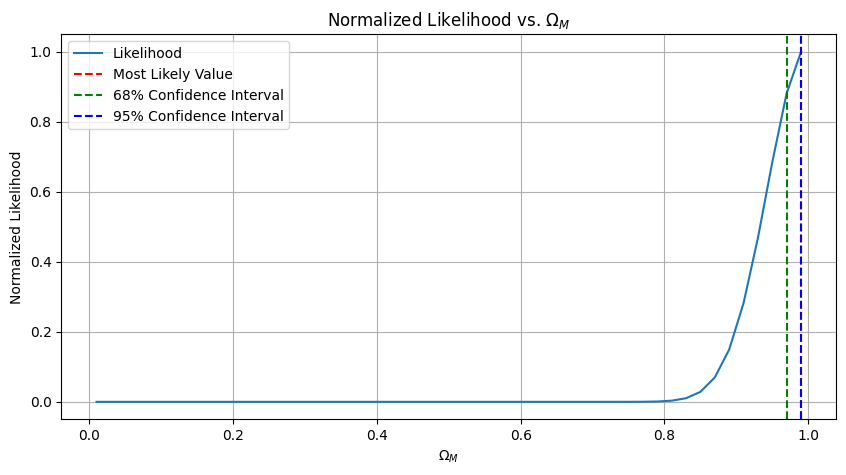

In [162]:
# Fixed values
w = -0.985 # From Union 2.1 paper
Omega_K = 0.0001
k = 0

# Define min and max Omega_M for the range
min_omega_m = 0.01
max_omega_m = 0.99
omega_m_range = np.linspace(min_omega_m, max_omega_m, 50)

# Calculate, normalize likelihoods
likelihoods_m = np.array([log_likelihood(data_cov.values, data, {'Omega_M': omega_m, 'Omega_DE': 1 - omega_m - Omega_K - Omega_R, 'w': w, 'M_n': 25 - 5 * np.log10(70)}, vary_params, k=0) for omega_m in omega_m_range])
likelihoods_m[0] = likelihoods_m[1] # Resolve bug in abnormal dip in likelihood 

likelihoods_m_norm = np.exp(likelihoods_m - np.max(likelihoods_m))

# Fit a polynomial to the normalized likelihood data
coefficients = np.polyfit(omega_m_range, likelihoods_m_norm, 5)
polynomial = np.poly1d(coefficients)

# Sample the polynomial within the omega_m_range
x_fine = np.linspace(min_omega_m, max_omega_m, 1000)
y_fine = polynomial(x_fine)

# Maximum likelihood value
max_x = x_fine[np.argmax(y_fine)]
most_likely_omega_m = omega_m_range[np.argmax(likelihoods_m_norm)]

# Most likely values
print("Most likely Omega_M:", max_x)
print("Most likely Omega_DE:", 1 - max_x)
print("Most likely Omega_M (array max):", most_likely_omega_m)

# Calculate confidence intervals
cumulative_m_likelihood = np.cumsum(likelihoods_m_norm)
cumulative_m_likelihood /= cumulative_m_likelihood[-1]  # Normalize to sum to 1

index_68 = np.where(cumulative_m_likelihood >= 0.68)[0][0]
index_95 = np.where(cumulative_m_likelihood >= 0.95)[0][0]
omega_m_68 = omega_m_range[index_68]
omega_m_95 = omega_m_range[index_95]

# Confidence interval bounds
print("68% confidence interval goes up to:", omega_m_68)
print("95% confidence interval goes up to:", omega_m_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(omega_m_range, likelihoods_m_norm, label='Likelihood')
plt.axvline(x=most_likely_omega_m, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=omega_m_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=omega_m_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $\\Omega_M$')
plt.xlabel('$\\Omega_M$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [164]:
print("All likelihood values:", likelihoods_m)

All likelihood values: [-701.00836125 -701.00836125 -436.0727563  -251.0547591  -117.80768726
  -19.44891504   54.66267932  111.50071761  155.78104544  190.77594237
  218.8052783   241.54375667  260.21910174  275.74331368  288.80160503
  299.91387861  309.47797336  317.80056898  325.1195764   331.62056174
  337.44893402  342.71907434  347.52124274  351.9268429   355.99246706
  359.76302487  363.27417826  366.55424521  369.6257048   372.50637018
  375.21034129  377.74874498  380.13033258  382.36196321  384.44898376
  386.39554483  388.20483955  389.87931605  391.42083204  392.83079025
  394.11024117  395.25996993  396.28056676  397.17247804  397.93605227
  398.57158172  399.0793158   399.45950144  399.71237943  399.83822181]


Most likely w: -0.005102040816326536
68% confidence interval for w goes up to: 0.06632653061224486
95% confidence interval for w goes up to: 0.18877551020408162


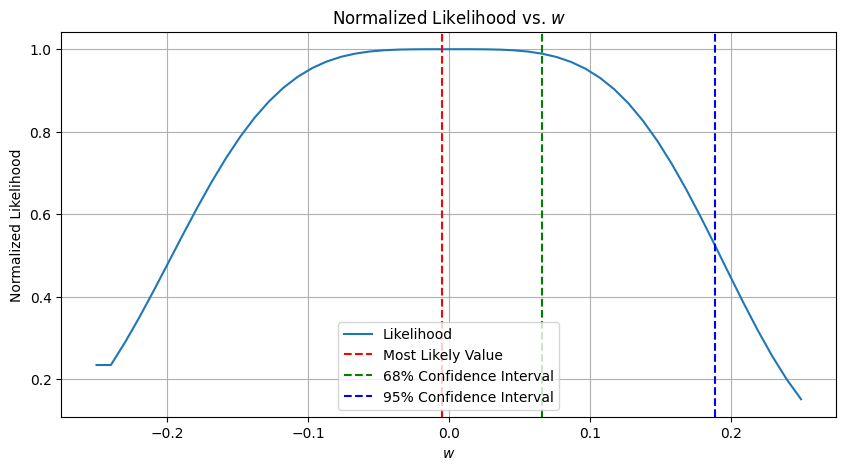

In [163]:
# Fixed values
fixed_omega_m = 0.276 # From Union 2.1 paper
Omega_K = 0.0001
k = 0

# Define min and max w for the range
min_w = -0.25
max_w = 0.25
w_range = np.linspace(min_w, max_w, 50)

# Calculate, normalize likelihoods
likelihoods_w = np.array([log_likelihood(data_cov.values, data, {'Omega_M': fixed_omega_m, 'Omega_DE': 1 - fixed_omega_m - Omega_K - Omega_R, 'w': w_val, 'M_n': 25 - 5 * np.log10(70)}, vary_params, k=0) for w_val in w_range])
likelihoods_w[0] = likelihoods_w[1] # Resolve bug in abnormal dip in likelihood 

likelihoods_w_norm = np.exp(likelihoods_w - np.max(likelihoods_w))

# Fit a polynomial to the normalized likelihood data
coefficients_w = np.polyfit(w_range, likelihoods_w_norm, 5)
polynomial_w = np.poly1d(coefficients_w)

# Sample the polynomial within the omega_m_range
x_fine_w = np.linspace(min_w, max_w, 1000)
y_fine_w = polynomial_w(x_fine_w)

# Maximum likelihood value
max_x_w = x_fine_w[np.argmax(y_fine_w)]
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]

# Most likely values
most_likely_w = w_range[np.argmax(likelihoods_w_norm)]
print("Most likely w:", most_likely_w)

# Calculate confidence intervals
cumulative_likelihood_w = np.cumsum(likelihoods_w_norm)
cumulative_likelihood_w /= cumulative_likelihood_w[-1]

index_68_w = np.where(cumulative_likelihood_w >= 0.68)[0][0]
index_95_w = np.where(cumulative_likelihood_w >= 0.95)[0][0]

w_68 = w_range[index_68_w]
w_95 = w_range[index_95_w]

# Confidence interval values
print("68% confidence interval for w goes up to:", w_68)
print("95% confidence interval for w goes up to:", w_95)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(w_range, likelihoods_w_norm, label='Likelihood')
plt.axvline(x=most_likely_w, color='r', linestyle='--', label='Most Likely Value')
plt.axvline(x=w_68, color='g', linestyle='--', label='68% Confidence Interval')
plt.axvline(x=w_95, color='b', linestyle='--', label='95% Confidence Interval')
plt.title('Normalized Likelihood vs. $w$')
plt.xlabel('$w$')
plt.ylabel('Normalized Likelihood')
plt.legend()
plt.grid(True)
plt.show()

In [165]:
print("All likelihood values:", likelihoods_w)

All likelihood values: [398.40398588 398.40398588 398.61760258 398.80820322 398.97717352
 399.12591426 399.25583534 399.3683493  399.46486503 399.54678077
 399.61547702 399.67230917 399.71859999 399.75563172 399.78463833
 399.80679712 399.8232207  399.83494852 399.84293846 399.8480583
 399.85107719 399.85265707 399.85334408 399.85356007 399.85359412
 399.85359409 399.85355934 399.85333997 399.85264224 399.8510348
 399.84795454 399.84271225 399.83449801 399.82238645 399.80534171
 399.78222233 399.75178602 399.71269401 399.66351576 399.60273307
 399.52874434 399.43986879 399.33435029 399.21036144 399.0660073
 398.89932919 398.70830849 398.49087004 398.24488586 397.96817864]
